In [1]:
import os
import re
import sys
import csv
import time
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy import optimize
from scipy.stats import chi2, norm
from scipy.integrate import quad
from scipy.special import erfinv

from sklearn.metrics.pairwise import pairwise_distances

import torch
import falkon

sys.path.insert(0, "../notebooks")
from plot_utils import plot_one_t, plot_two_t


/tmp/ipykernel_1677771/552375591.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Parameter testing

In [2]:
def from_path_to_plot(path:str, m=3000, l=1e-7, bin=30):
    with open(path) as f:
        # t_list = np.array([float(row.split()[0]) for row in f])
        t_list = np.array([float(row.split()[0]) for row in f])[:50]
        # t_list = np.random.choice(t_list, 100, replace=False)

    print("number of toys:", len(t_list))
    
    dof_fit, _, _ = chi2.fit(t_list, floc=0, fscale=1)
    _, ks_p_value = stats.kstest(t_list, "chi2", args=(dof_fit,))
    print("ks pvalue:", np.around(ks_p_value, 3))
    
    ref_chi2 = chi2(df=dof_fit)
    t_ref_bins  = np.arange(int(np.min(t_list))-50, int(np.max(t_list))+100, bin)
    xgrid_ref   = np.arange(int(np.min(t_list))-100, int(np.max(t_list))+100, 2)
    plot_one_t(
        t_distribution  = t_list,
        t_bins          = t_ref_bins,
        chi2            = ref_chi2,
        chi2_grid       = xgrid_ref,
        show_hist       = True,
        show_error      = False,
        compute_rate    = False,
        err_marker      = "o",
        err_markersize  = 10,
        err_capsize     = 5,
        err_elinewidth  = 4,
        err_capthick    = 4,
        err_color       = "black",
        figsize         = (10, 6),
        fontsize        = 18,
        cms             = False,
        cms_label       = "",
        cms_rlabel      = "",
        hist_ecolor     = ("#494B69", 1.0),
        hist_fcolor     = ("#494B69", 0.1),
        chi2_color      = ("#D8707C", 0.8),
        hist_lw         = 4,
        chi2_lw         = 6,
        hist_type       = "stepfilled",
        hist_label      = "$\it{t}$ distribution",
        chi2_label      = "Target $\chi^2$(dof=%.2f)"%(dof_fit),
        xlabel          = r"$t$",
        ylabel          = "Density",
        show_plot       = True,
        save_plot       = False,
        plot_name       = "t_distribution_"+str(l)+"_"+str(M),
        plot_path       = "",
        plot_format     = "png",
        return_fig      = False,
        plot_params     = True,
        hyperparams     = str(l)+", "+str(M),

    )

In [3]:
def path_to_Z(path_ref:str, path_sig):

    with open(path_ref) as f1:
        t_ref_final = np.array([float(row.split()[0]) for row in f1])
    with open(path_sig) as f:
        t_data_final = np.array([float(row.split()[0]) for row in f])

    dof_fit, _, _ = chi2.fit(t_ref_final, floc=0, fscale=1)
    _, ks_p_value = stats.kstest(t_ref_final, "chi2", args=(dof_fit,))
    print("KS - p value:\t",np.around(ks_p_value,4))
    
    t_obs = np.median(t_data_final)
    # p_val = 1 - ref_chi2.cdf(t_obs)
    print("p_value obs:\t", np.around(1-chi2.cdf(np.median(t_data_final), dof_fit),3))
    Z_obs     = norm.ppf(chi2.cdf(np.median(t_data_final), dof_fit))
    t_obs_err = 1.2533*np.std(t_data_final)*1./150
    Z_obs_p   = norm.ppf(chi2.cdf(np.median(t_data_final)+t_obs_err, dof_fit))
    Z_obs_m   = norm.ppf(chi2.cdf(np.median(t_data_final)-t_obs_err, dof_fit))

    print('Z = %s (+%s/-%s)\n'%(str(np.around(Z_obs, 5)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2))))
    

## $N_0=3000$

### N(0)=1000

number of toys: 50
ks pvalue: 0.876


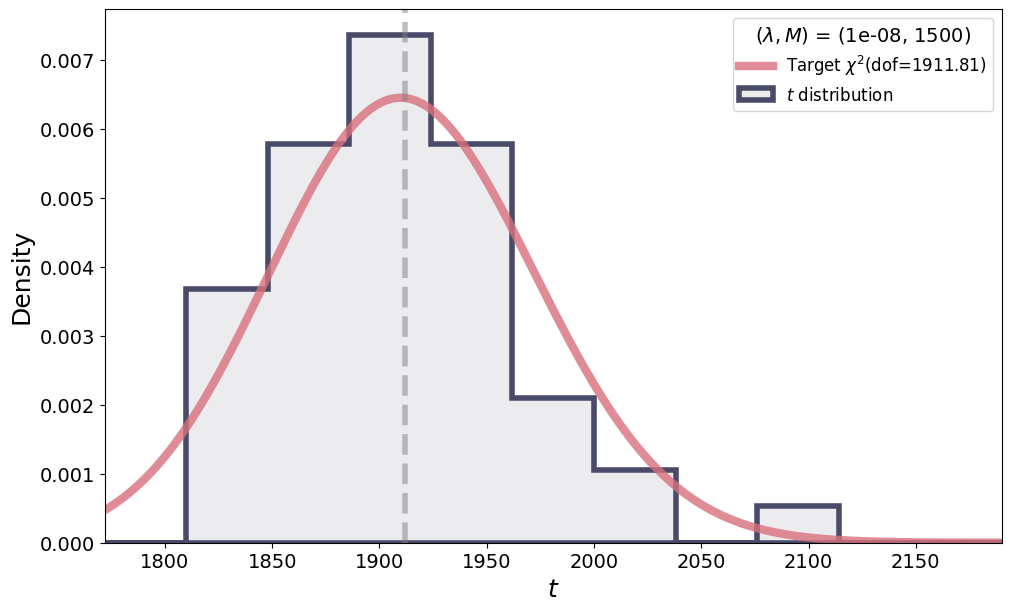

In [38]:
M=1500; l=1e-8
# path="../output/bank_data/N_study/again/2024_2_29_19_17_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1000.csv"
path1a="../output/bank_data/test_params/2024_2_29_13_36_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
# path1a="../output/bank_data/test_params/2024_3_1_14_52_ref_3000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
from_path_to_plot(path1a,M,l, bin=38)

In [39]:
path_sig1a = "../output/bank_data/N_study/again/signal/2024_3_1_15_51_ref_3000_bkg_1000_sig_20/ttest_time_1e-08_1500.csv"
# path_sig1a = "../output/bank_data/N_study/again/signal/2024_3_1_17_56_ref_3000_bkg_1000_sig_30/ttest_time_1e-08_1500.csv"
path_to_Z(path1a, path_sig1a)


KS - p value:	 0.9146
p_value obs:	 0.193
Z = 0.86517 (+0.01/-0.01)



### N(0)=1200

number of toys: 50
ks pvalue: 0.954


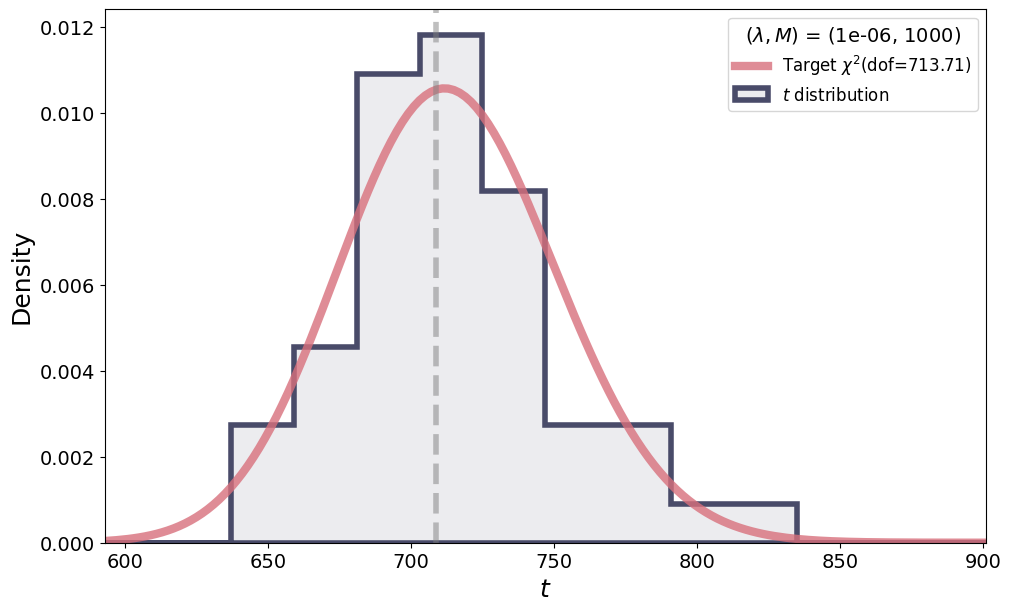

In [40]:
M=1000; l=1e-6
path1b="../output/bank_data/N_study/again/2024_2_29_20_9_ref_3000_bkg_1200_sig_0/ttest_time_1e-06_1000.csv"
from_path_to_plot(path1b,M,l, bin=22)

In [41]:
path_sig1b = "../output/bank_data/N_study/again/signal/2024_3_1_16_22_ref_3000_bkg_1200_sig_24/ttest_time_1e-06_1000.csv"
path_to_Z(path1b, path_sig1b)


KS - p value:	 0.9884
p_value obs:	 0.115
Z = 1.19995 (+0.01/-0.01)



M=1000, l=1e-7

number of toys: 50
ks pvalue: 0.64


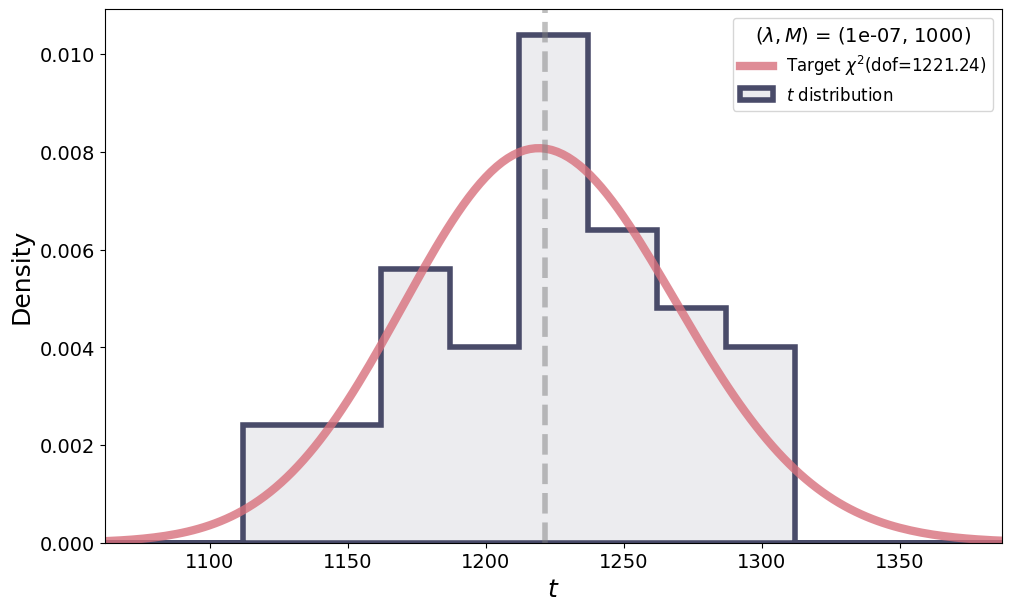

In [42]:
M=1000; l=1e-7
path1c="../output/bank_data/N_study/again/2024_2_29_20_9_ref_3000_bkg_1200_sig_0/ttest_time_1e-07_1000.csv"
from_path_to_plot(path1c,M,l,bin=25)

In [43]:
path_sig1c = "../output/bank_data/N_study/again/signal/2024_3_1_16_24_ref_3000_bkg_1200_sig_24/ttest_time_1e-07_1000.csv"
path_to_Z(path1c, path_sig1c)


KS - p value:	 0.9748
p_value obs:	 0.178
Z = 0.922 (+0.01/-0.01)



M=1500; l=1e-8

number of toys: 50
ks pvalue: 0.848


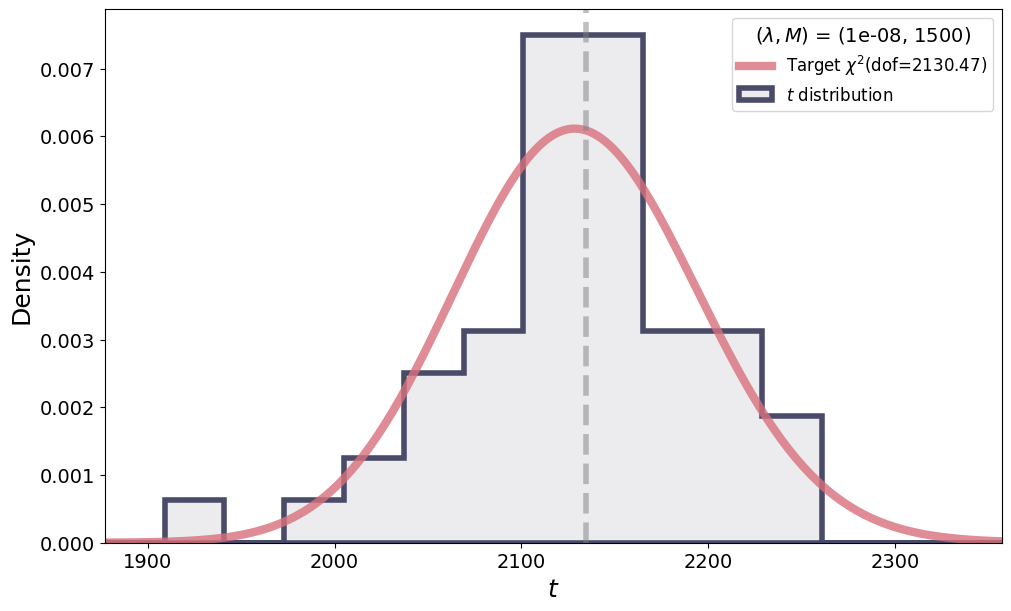

In [44]:
M=1500; l=1e-8
path1d="../output/bank_data/N_study/again/2024_2_29_20_9_ref_3000_bkg_1200_sig_0/ttest_time_1e-08_1500.csv"
from_path_to_plot(path1d,M,l, bin=32)

In [45]:
path_sig1d = "../output/bank_data/N_study/again/signal/2024_3_1_16_29_ref_3000_bkg_1200_sig_24/ttest_time_1e-08_1500.csv"
path_to_Z(path1d, path_sig1d)


KS - p value:	 0.9902
p_value obs:	 0.28
Z = 0.58308 (+0.01/-0.01)



## $N_0=5000$

### N(0)=1000

M=1000; l=1e-8

number of toys: 50
ks pvalue: 0.748


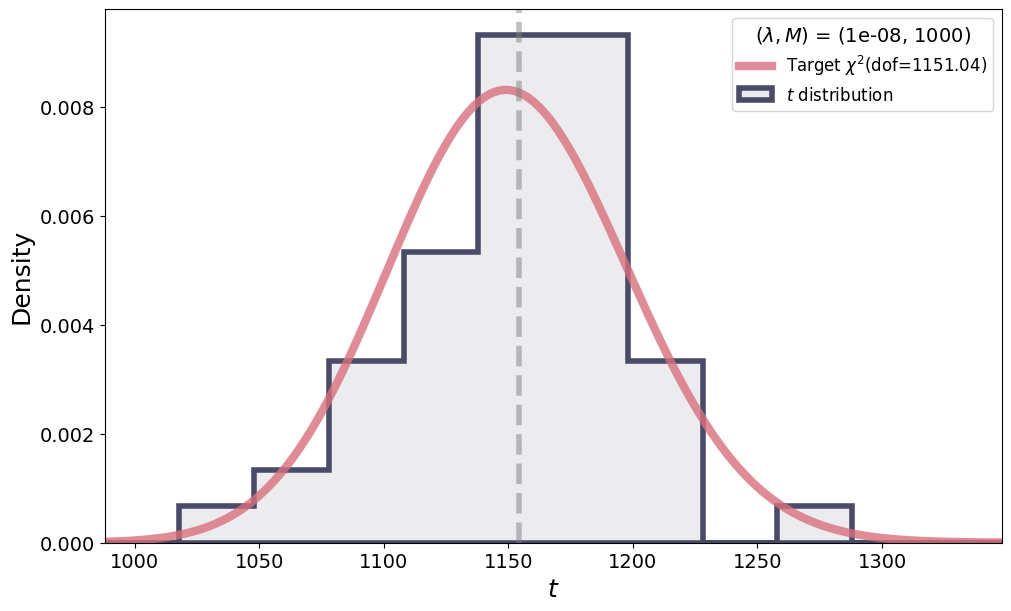

In [46]:
M=1000; l=1e-8
path_ref2 = "../output/bank_data/test_params/2024_2_29_14_34_ref_5000_bkg_1000_sig_0/ttest_time_1e-08_1000.csv"
from_path_to_plot(path_ref2,M,l, bin=30)

In [47]:
path_sig2 = "../output/bank_data/N_study/again/signal/2024_3_1_17_1_ref_5000_bkg_1000_sig_20/ttest_time_1e-08_1000.csv"
path_to_Z(path_ref2, path_sig2)

KS - p value:	 0.9393
p_value obs:	 0.188
Z = 0.88553 (+0.01/-0.01)



M=1500; l=1e-8

number of toys: 50
ks pvalue: 0.699


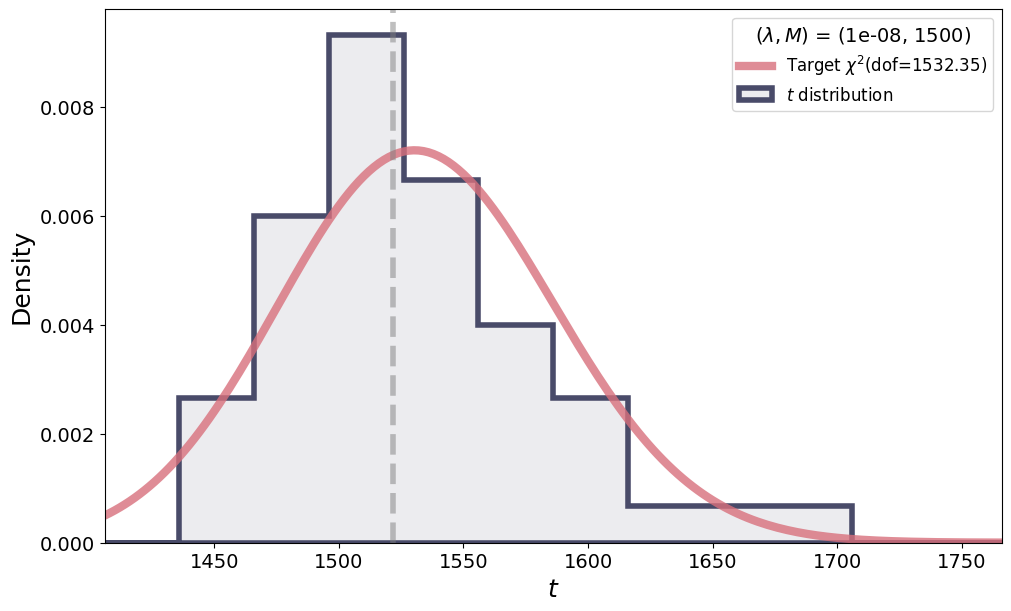

In [48]:
M=1500; l=1e-8
path2a="../output/bank_data/N_study/again/2024_2_29_21_50_ref_5000_bkg_1000_sig_0/ttest_time_1e-08_1500.csv"
from_path_to_plot(path2a,M,l, bin=30)

In [49]:
path_sig2a = "../output/bank_data/N_study/again/signal/2024_3_1_17_17_ref_5000_bkg_1000_sig_20/ttest_time_1e-08_1500.csv"
path_to_Z(path2a, path_sig2a)


KS - p value:	 0.9305
p_value obs:	 0.19
Z = 0.87649 (+0.01/-0.01)



M=500; l=1e-7


number of toys: 50


ks pvalue: 0.978


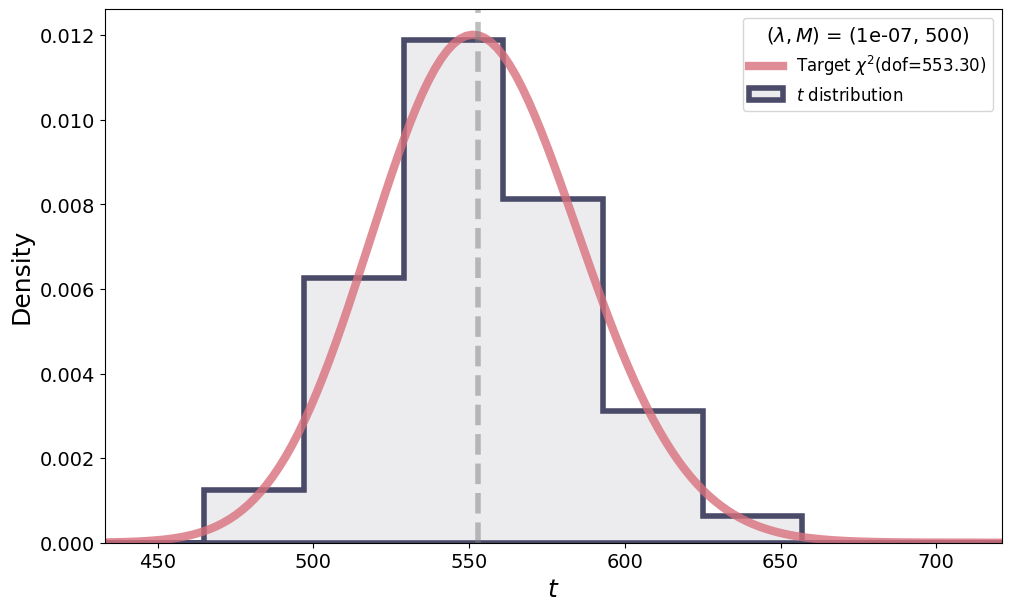

In [50]:
M=500; l=1e-7
path2b="../output/bank_data/N_study/again/2024_2_29_21_50_ref_5000_bkg_1000_sig_0/ttest_time_1e-07_500.csv"
from_path_to_plot(path2b,M,l, bin=32)

In [51]:
path_sig2b = "../output/bank_data/N_study/again/signal/2024_3_4_9_27_ref_5000_bkg_1000_sig_20/ttest_time_1e-07_500.csv"
path_to_Z(path2b, path_sig2b)


KS - p value:	 0.9361
p_value obs:	 0.205
Z = 0.82416 (+0.01/-0.01)



### N(0)=1200

M=1500; l=1e-6


number of toys: 50
ks pvalue: 0.986


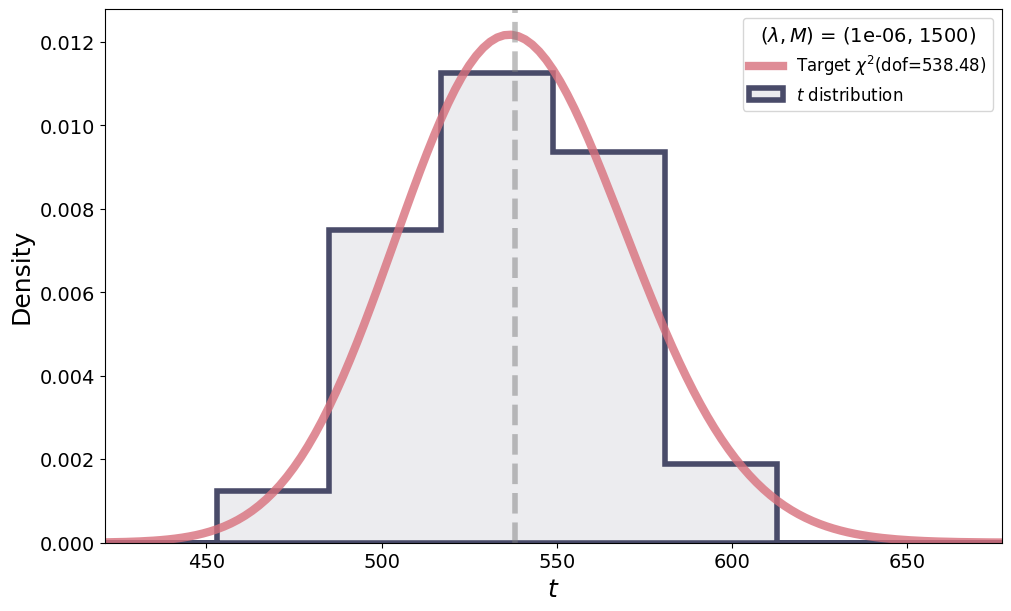

In [52]:
M=1500; l=1e-6
path2c="../output/bank_data/N_study/again/2024_2_29_22_42_ref_5000_bkg_1200_sig_0/ttest_time_1e-06_1000.csv"
from_path_to_plot(path2c,M,l, bin=32)

In [53]:
path_sig2c = "../output/bank_data/N_study/again/signal/2024_3_4_9_50_ref_5000_bkg_1200_sig_24/ttest_time_1e-06_1000.csv"
path_to_Z(path2c, path_sig2c)


KS - p value:	 0.9873
p_value obs:	 0.031
Z = 1.86449 (+0.01/-0.01)



## $N_0=8000$

### N(0)=1000

M=500; l=1e-7


number of toys: 50
ks pvalue: 0.986


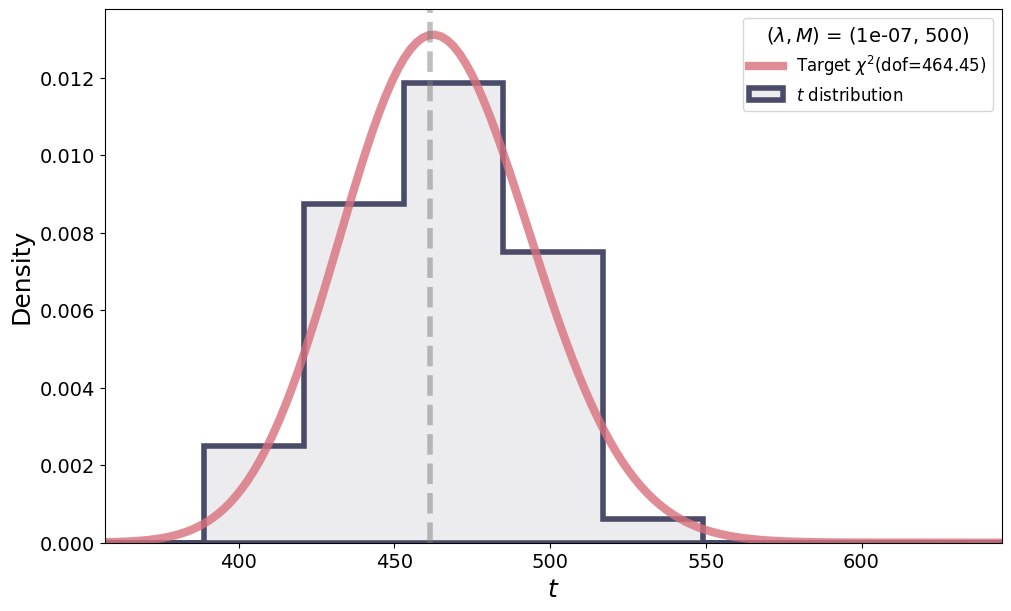

In [54]:
M=500; l=1e-7
path3a="../output/bank_data/N_study/again/2024_3_1_0_23_ref_8000_bkg_1000_sig_0/ttest_time_1e-07_500.csv"
from_path_to_plot(path3a,M,l, bin=32)

In [55]:
path_sig3a = "../output/bank_data/N_study/again/signal/2024_3_4_9_30_ref_8000_bkg_1000_sig_20/ttest_time_1e-07_500.csv"
path_to_Z(path3a, path_sig3a)


KS - p value:	 0.9969
p_value obs:	 0.16
Z = 0.99527 (+0.01/-0.01)



N(0)=1200

In [56]:
# M=500; l=1e-7
# path3b="../output/bank_data/N_study/again/2024_3_1_1_14_ref_8000_bkg_1200_sig_0/ttest_time_1e-07_500.csv"
# from_path_to_plot(path3b,M,l, bin=32)

## SIGNAL

In [57]:
def extract_Nsig_SO(file:str):
    matches = re.search(r'_sig_(\d+)_SOn', file)
    return int(matches.group(1))